In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

In [4]:
df=pd.read_csv("/Users/chenxiaofeng/Desktop/cleaned_heart_data.csv")
print(len(df))
print(df.dtypes)

371460
State                     object
Sex                       object
GeneralHealth             object
PhysicalHealthDays       float64
MentalHealthDays         float64
PhysicalActivities        object
SleepHours               float64
HadHeartAttack            object
HadAngina                 object
HadStroke                 object
HadAsthma                 object
HadCOPD                   object
HadDepressiveDisorder      int64
HadKidneyDisease          object
HadArthritis              object
HadDiabetes                int64
SmokerStatus              object
AgeCategory               object
BMI                      float64
AlcoholDrinkers           object
SleepCategory             object
HadHeartAttackNumeric      int64
dtype: object


In [5]:
for feature in df.columns:
    print(feature)
    print(df[feature].unique(),"\n")

State
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands'] 

Sex
['Female' 'Male'] 

GeneralHealth
['Very good' 'Excellent' 'Fair' 'Poor' 'Good'] 

PhysicalHealthDays
[ 0.  2.  1.  8.  5. 30.  4. 23. 14. 15.  3. 10.  7. 25.  6. 21. 20. 29.
 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 18. 19. 22.] 

MentalHealthDays
[ 0.  3.  9.  5. 15. 20. 14. 10. 18.  1.  2. 30.  4.  6.  7. 25.  8. 27.
 21. 12. 16. 13. 28. 29

In [7]:
df=df.drop(columns=["State","HadHeartAttack"])
columns_to_convert = ['PhysicalActivities',"HadAngina","HadStroke","HadAsthma","HadCOPD","HadKidneyDisease","HadArthritis","AlcoholDrinkers"]  # List your columns here

for column in columns_to_convert:
    df[column] = df[column].str.strip().str.lower().replace({'yes': 1, 'no': 0})

In [10]:
df["GeneralHealth"].replace({'Poor':0,'Fair':1,'Good':2,'Very good':3,'Excellent':4},inplace=True) 

df["SmokerStatus"].replace({"Never":0,'Sometimes':1,'Former':2,"Everyday":3},inplace=True) 

df["AgeCategory"].replace({'18-24':0,'25-29':1,'30-34':2,'35-39':3,'40-44':4,'45-49':5,'50-54':6,'55-59':7,'60-64':8,'65-69':9,'70-74':10,'75-79':11,'80+':12},inplace=True) 

df["SleepCategory"].replace({'Very Short':0,'Short':1,'Recommended':2,'Long':3,'Very Long':4},inplace=True)

In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
categorical_columns = ['Sex']
encoded_features = encoder.fit_transform(df[categorical_columns]).toarray()

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_df], axis=1)

In [12]:
df.shape

(371460, 21)

In [13]:
from sklearn.model_selection import train_test_split
y = df.pop('HadHeartAttackNumeric')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

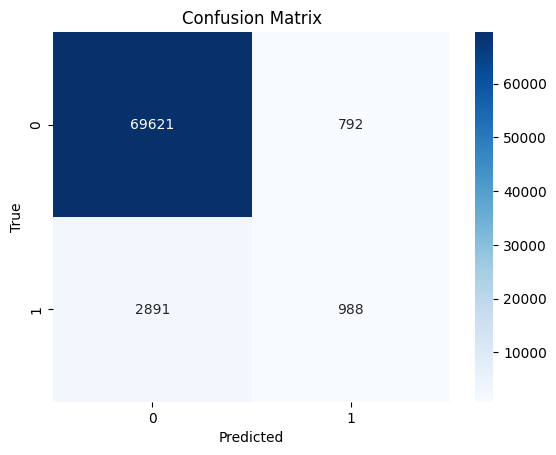

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

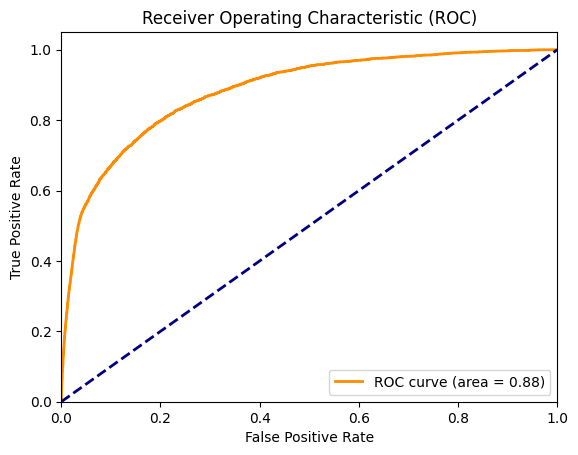

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


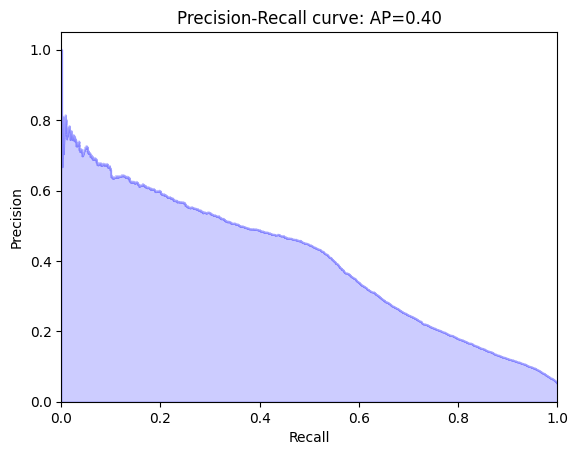

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, model.predict_proba(X_test_scaled)[:,1])

precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:,1])

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [20]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test_scaled)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs.ravel()]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     70413
           1       0.56      0.25      0.35      3879

    accuracy                           0.95     74292
   macro avg       0.76      0.62      0.66     74292
weighted avg       0.94      0.95      0.94     74292

